In [1]:
import h5py
import sys
import numpy as np
import bisect

import matplotlib.pyplot as plt
import matplotlib.cm as cm

class Histogram(object):
    """Histogram.
    """

    def __init__(self, values):
        """Create a histogram for the given values using the Freedman-Diaconis rule for the bin width.

        :param values: the values from which the histogram will be computed
        """
        self.num_instances = len(values)

        # Get the number of bins.
        v_min, v_25, v_75, v_max = np.percentile(values, [0, 25, 75, 100])
        # freedman_diaconis_width = 2 * (v_75 - v_25) / (len(values) ** (1/3.0))
        freedman_diaconis_width = (v_max - v_min) / (len(values) ** (1/3.0))
        num_bins = int(round((v_max - v_min) / freedman_diaconis_width))
        assert num_bins > 0

        # Fill the bins.
        self.heights, self.bin_edges = np.histogram(values, bins=num_bins)

    def find_bin(self, value):
        """Find the bin index of the given value.

        :param value: some value
        :return: bin index
        """
        bin_index = bisect.bisect_left(self.bin_edges, value) - 1
        bin_index = max(bin_index, 0)
        bin_index = min(bin_index, len(self.heights)-1)
        return bin_index

    def bin_probability(self, bin_index):
        """Return the bin probability of the desired bin.

        :param bin_index: index of the bin
        :return: probability of the bin
        """
        assert 0 <= bin_index <= len(self.heights) - 1
        return self.heights[bin_index] / float(self.num_instances)

class NaiveBayesClassifier(object):
    """Naive Bayes classifier.
    """

    def __init__(self):
        self.num_instances = None  # Number of instances that were used in training.
        self.num_feats = None  # Number of features that were used in training.
        self.classes = None  # The classes that were found in training.
        self.histograms = {}  # Dict with histograms, key: class, value: list with histograms for all features.
        self.priors = {}  # Dict with priors, key: class, value: prior of the class.

    def train(self, train_x, train_y):
        """Train the classifier.

        :param train_x: training x data
        :param train_y: training y data
        """
        assert train_x.shape[0] == len(train_y)
        self.num_instances = train_x.shape[0]
        self.num_feats = train_x.shape[1]
        self.classes = np.unique(train_y)

        # Create one histogram for each class and each feature.
        self.histograms.clear()
        self.priors.clear()
        for cl in self.classes:
            # Get the data of the current class.
            train_x_cl = [train_x[k] for k in range(self.num_instances) if train_y[k] == cl]
            num_instances_cl = len(train_x_cl)
            self.priors[cl] = num_instances_cl / float(self.num_instances)

            # Create one histogram per feature.
            self.histograms[cl] = []
            for i in range(self.num_feats):
                histo_points = [train_x_cl[k][i] for k in range(num_instances_cl)]
                self.histograms[cl].append(Histogram(histo_points))

    def probabilities_single(self, test_x):
        """Compute the class probabilities of a single instance.

        :param test_x: test x data of a single instance
        :return: probabilities of test_x for each class
        """
        assert len(test_x) == self.num_feats,\
            "NaiveBayesClassifier.probabilities_single(): Number of features in test and training must be the same."

        probs = {}
        for cl in self.classes:
            # Compute the likelihood.
            prob = self.priors[cl]
            for i in range(self.num_feats):
                # Find height of histogram bin with class cl that contains test_x[i].
                histo = self.histograms[cl][i]
                bin_index = histo.find_bin(test_x[i])
                prob *= histo.bin_probability(bin_index)
            probs[cl] = prob
        return probs

    def predict_single(self, test_x):
        """Predict the class of a single instance.

        :param test_x: test x data of a single instance
        :return: predicted class of test_x
        """
        probs = self.probabilities_single(test_x)
        max_cl = max(probs.keys(), key=lambda cl: probs[cl])
        return max_cl

    def predict(self, test_x):
        """Predict the classes of the given sample.

        :param test_x: test x data
        :return: predicted classes of test_x
        """
        assert test_x.shape[1] == self.num_feats,\
            "NaiveBayesClassifier.predict(): Number of features in test and training must be the same."
        return np.array([self.predict_single(test_x[i]) for i in range(test_x.shape[0])])


def use_subset(condition, x, y):
    sub_ix = np.where((y == condition[0]) | (y == condition[1]))
    y_sub = (y[sub_ix]).squeeze()
    # rename labels
    y_sub[y_sub == condition[0]] = 0
    y_sub[y_sub == condition[1]] = 1
    x_sub = (x[sub_ix, :]).squeeze()
    return x_sub, y_sub

In [2]:
f = h5py.File("data/digits.h5")
images = f["images"].value
labels = f["labels"].value
f.close()

print(images.shape)
print(labels.shape)

(120000, 9, 9)
(120000,)


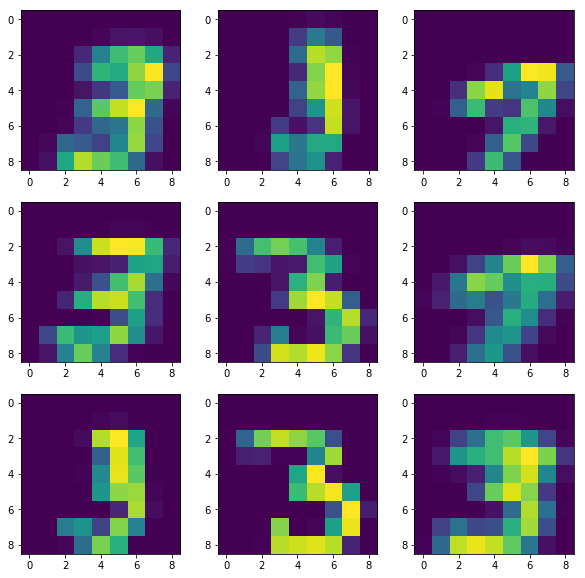

In [40]:
# use only digit 3
x, y = use_subset([3, 7], images, labels)

f, axarr = plt.subplots(3, 3, figsize=(10, 10))
for i in range(9):
    axarr[i % 3, i//3].imshow(x[i,:,:])

plt.show()

In [35]:
class GenerativeBayes(NaiveBayesClassifier):
    def sample_naive_bayes(self, digitIx):
        pxValue = np.zeros(len(self.histograms[digitIx]))
        for i, px in enumerate(self.histograms[digitIx]):
            ql = np.cumsum(px.heights)
            ql = ql / px.num_instances
            t = np.random.random_sample()
            l_ix = np.where(ql >= t)
            l = l_ix[0][0]
            pxValue[i] = (px.bin_edges[l + 1] - px.bin_edges[l]) * np.random.random_sample() + px.bin_edges[l]
        return pxValue

In [36]:
# reshape
x = np.reshape(x, (x.shape[0], -1))

gnb = GenerativeBayes()
gnb.train(x, y)

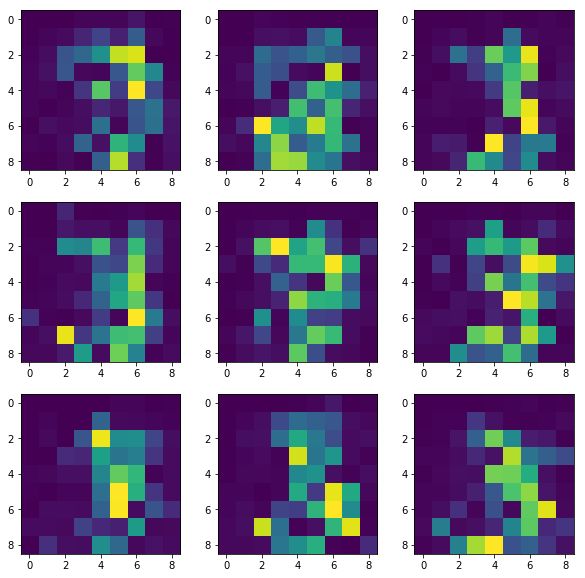

In [43]:
# use only digit 3
x, y = use_subset([3, 3], images, labels)

f, axarr = plt.subplots(3, 3, figsize=(10, 10))
for i in range(9):
    new_px = gnb.sample_naive_bayes(0)
    new_px = new_px.reshape(images[0,:,:].shape)
    axarr[i % 3, i//3].imshow(new_px)

plt.show()